<a href="https://colab.research.google.com/github/jxin11/waste-image-classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Import Libraries

In [1]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.1 MB/s 


In [2]:
pip install helper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for helper: filename=helper-2.5.0-py2.py3-none-any.whl size=19188 sha256=6146b511bb7454fdd8aec41bcc6bfebee17f7e361b78191918dc58a43afb55dc
  Stored in directory: /root/.cache/pip/wheels/85/68/52/33a3eed6a95667d7b9a38afeee13928e3f95912753f1120633
Successfully built helper


In [3]:
import cv2
import glob
import random
import visualkeras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from keras.utils import np_utils
from collections import Counter, OrderedDict
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                                    Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score

# Read & Store Images

In [ ]:
!git clone https://github.com/garythung/trashnet

fatal: destination path 'trashnet' already exists and is not an empty directory.


In [ ]:
!unzip /content/trashnet/data/dataset-resized.zip

In [ ]:
SIZE = 128

filepath = []
images = []
labels = []

# Read & Sort filepath
for folder_path in glob.glob("/content/dataset-resized/*"):
  for img_path in glob.glob(folder_path + "/*.jpg"):
    filepath.append(img_path)
  
filepath.sort()

# Read images & labels
for img_path in filepath:
  label = img_path.split("/")[-2]
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))   # Resize image
  images.append(img)
  labels.append(label)

In [ ]:
print("Total no. of images: ", len(images))
print("Total no. of labels: ", len(labels))
print("Total no. of unique labels: ", Counter(labels))

Total no. of images:  2527
Total no. of labels:  2527
Total no. of unique labels:  Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


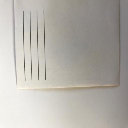

paper


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

# Prepare Train & Test Sets

In [ ]:
# Shuffle images
temp = list(zip(images, labels))
random.Random(0).shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

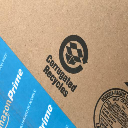

cardboard


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

In [ ]:
# Train test split
img_train, img_test, label_train, label_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=0)

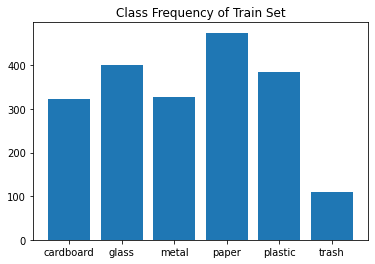


Train Set
cardboard: 322 (15.93%)
glass: 401 (19.84%)
metal: 328 (16.23%)
paper: 475 (23.5%)
plastic: 385 (19.05%)
trash: 110 (5.44%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(label_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

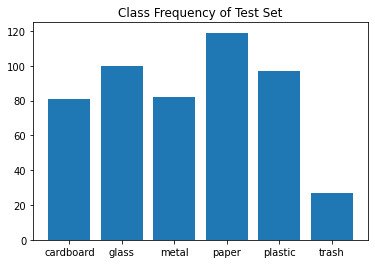


Test Set
cardboard: 81 (16.01%)
glass: 100 (19.76%)
metal: 82 (16.21%)
paper: 119 (23.52%)
plastic: 97 (19.17%)
trash: 27 (5.34%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(label_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Convert to numpy array

In [ ]:
# Before conversion
print("X_train: ", "type-", type(img_train), "; size-", len(img_train))
print("y_train: ", "type-", type(label_train), "; size-", len(label_train))

X_train:  type- <class 'list'> ; size- 2021
y_train:  type- <class 'list'> ; size- 2021


In [ ]:
img_train = np.array(img_train, dtype="float")
img_test = np.array(img_test, dtype="float")
label_train = np.array(label_train)
label_test = np.array(label_test)

In [ ]:
# After conversion
print("X_train: ", "type-", type(img_train), "; size-", img_train.shape)
print("y_train: ", "type-", type(label_train), "; size-", label_train.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (2021, 128, 128, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (2021,)


# Label Encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(label_train)

LabelEncoder()

In [ ]:
label_encoded_train = le.transform(label_train)
label_encoded_test = le.transform(label_test)

In [ ]:
le.classes_

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# One Hot Encoding

In [ ]:
n_classes = len(le.classes_)

print("Shape before OHE: ", label_encoded_train.shape)

label_encoded_train = np_utils.to_categorical(label_encoded_train,n_classes)
label_encoded_test = np_utils.to_categorical(label_encoded_test,n_classes)

print("Shape after OHE: ", label_encoded_train.shape)

Shape before OHE:  (2021,)
Shape after OHE:  (2021, 6)


# Normalization



In [ ]:
img_train, img_test = img_train/255.0, img_test/255.0

# Data Augmentation
Ref: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Data augmentation is only applied to train set.

In [ ]:
datagen = ImageDataGenerator(rotation_range=20, 
                             horizontal_flip=True, vertical_flip=True,
                             zoom_range=0.2, shear_range=0.2)

**batch_size in ImageDataGenerator.flow - If you have 1000 images in your dataset and the batch size is defined as 10. Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.

Original Image: 


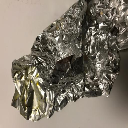


Data Augmentation: 


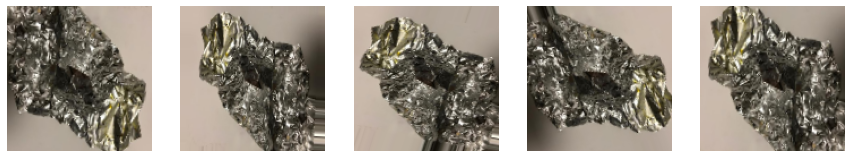

In [ ]:
# Take an image as example

print("Original Image: ")
cv2_imshow(img_train[123]*255)

width, height, channel = img_train.shape[1], img_train.shape[2], img_train.shape[3]
iter = datagen.flow((img_train[123]).reshape(1, width, height, channel), batch_size=1)

# generate samples and plot
print("\nData Augmentation: ")
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

# generate batch of images
for i in range(5):

  image = next(iter)
  image = np.squeeze(image)
  
  # plot image
  ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

# Deep Learning Model Components
Ref: 
1. https://medium.com/the-owl/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0
2. https://arxiv.org/abs/1602.07261

## Convolutional Block

In [4]:
def conv2d(x, filters, kernel_size, strides=1, pad='same', act=True, name=None):
  x = Conv2D(filters=filters, kernel_size=kernel_size,
             strides=strides, padding=pad,
             data_format='channels_last', use_bias=False,
             name=name+'conv2d')(x)
  x = BatchNormalization(axis=3, scale=False, name=name+'conv2d_bn')(x)
  if act:
    x = Activation('relu', name=name+'conv2d_act')(x)
  return x

Batch Norm reduces the internal covariate shift of the network. <br>
Batch Norm has a regularization effect. <br>
In CNN, each feature map will have a single mean and standard deviation. <br>
The original paper talks about applying batch norm just before the activation function, it has been found in practice that applying batch norm after the activation yields better results. <br>
Ref: 
1. https://www.baeldung.com/cs/batch-normalization-cnn
2. https://blog.paperspace.com/busting-the-myths-about-batch-normalization/

## Inception ResNet A Block

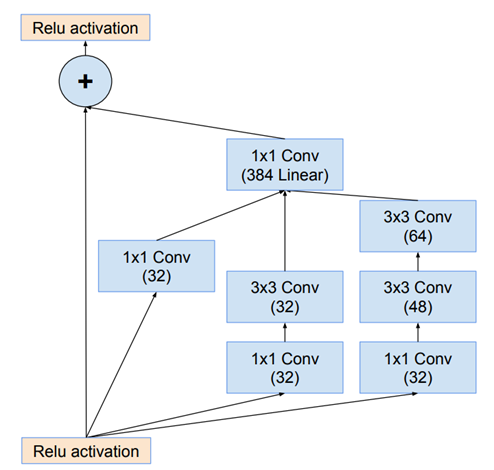

In [6]:
def incResA(x, scale, name=None):

  branch0 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 32, 3, 1, 'same', True, name=name+'b1_2')

  branch2 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 48, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, 64, 3, 1, 'same', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 384, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet B Block

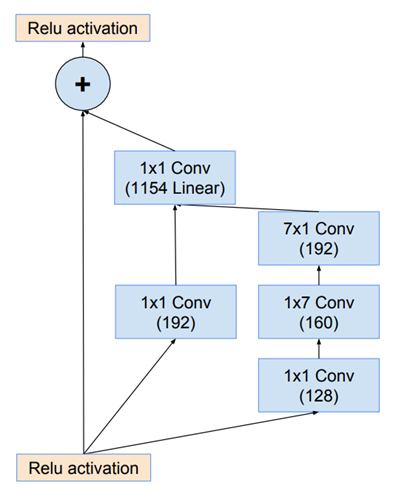

In [7]:
def incResB(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 128, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 160, [1,7], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 192, [7,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 1154, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet C Block

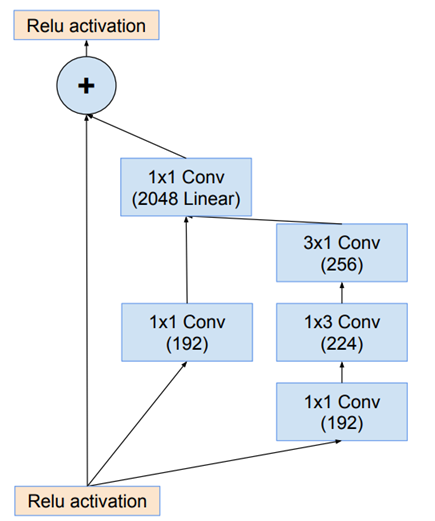

In [8]:
def incResC(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 224, [1,3], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 256, [3,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 2048, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Reduction A Block

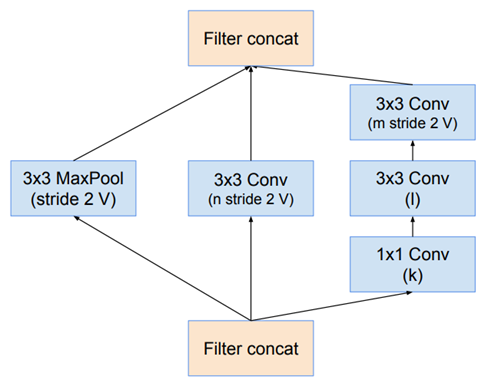

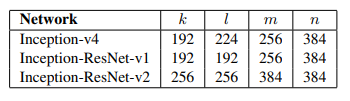

In [13]:
def redA(x, name=None):

  n = 384; k = 256; l = 256; m = 384

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, n, 3, 2, 'valid', True, name=name+'b1')

  branch2 = conv2d(x, k, 1, 2, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, l, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, m, 3, 2, 'valid', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

## Reduction B Block

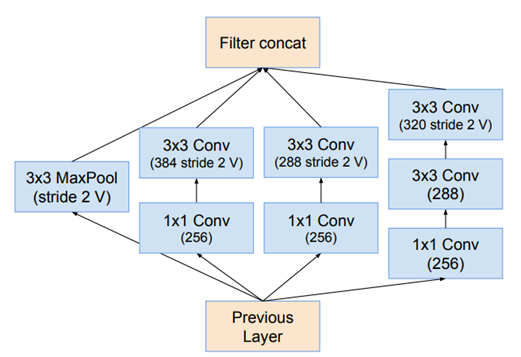

In [12]:
def redB(x, name=None):

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 384, 3, 2, 'valid', True, name=name+'b1_2')

  branch2 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 288, 3, 2, 'valid', True, name=name+'b2_2')

  branch3 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b3_1')
  branch3 = conv2d(branch3, 288, 3, 1, 'same', True, name=name+'b3_2')
  branch3 = conv2d(branch3, 320, 3, 2, 'valid', True, name=name+'b3_3')

  branches = [branch0, branch1, branch2, branch3]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Stem Block

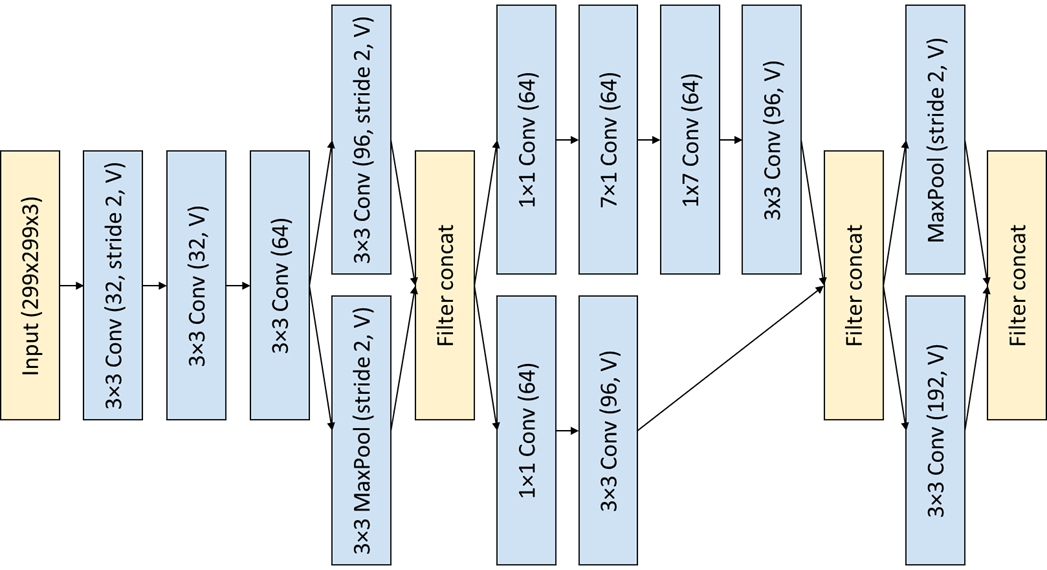

** Input size = 128

In [40]:
def stem(img_input):

  x = conv2d(img_input, 32, 3, 2, 'valid', True, name='conv1')
  x = conv2d(x, 32, 3, 1, 'valid', True, name='conv2')
  x = conv2d(x, 64, 3, 1, 'same', True, name='conv3')
  
  x_11 = MaxPooling2D((3,3), 2, 'valid', name='stem_br_11')(x)
  x_12 = conv2d(x, 96, 3, 2, 'valid', True, name='stem_br_12')
  
  x_1 = [x_11, x_12]
  x = Concatenate(axis=3, name='stem_filt_concat1')(x_1)
  
  x_21 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_211')
  x_21 = conv2d(x_21, 96, 3, 1, 'valid', True, name='stem_br_212')

  x_22 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_221')
  x_22 = conv2d(x_22, 64, [7,1], 1, 'same', True, name='stem_br_222')
  x_22 = conv2d(x_22, 64, [1,7], 1, 'same', True, name='stem_br_223')
  x_22 = conv2d(x_22, 96, 3, 1, 'valid', True, name='stem_br_224')

  x_2 = [x_21, x_22]
  x = Concatenate(axis=3, name='stem_filt_concat2')(x_2)
  
  x_31 = conv2d(x, 192, 3, 1, 'valid', True, name='stem_br_31')  # 51 51 192 
  x_32 = MaxPooling2D((3,3), 1, 'valid', name='stem_br_32')(x)   # 27 27 192  26 26 192

  x_3 = [x_31, x_32]
  x = Concatenate(axis=3, name='stem_filt_concat3')(x_3)
  print('true')
  return x

# Deep Learning Model - Inception ResNetV2 Model

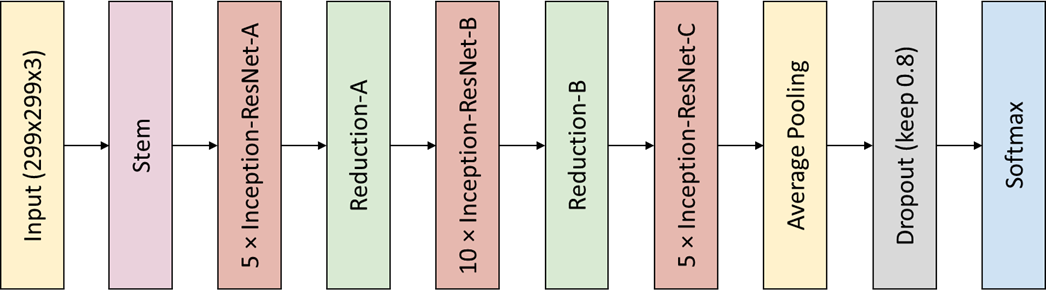

In [41]:
# Base Model

SIZE = 299
incResA_count = 5
incResB_count = 10
incResC_count = 5

img_input = Input(shape=(SIZE, SIZE, 3))
x = stem(img_input)

for i in range(incResA_count):
  x = incResA(x, 0.15, name='incResA_'+str(i))
x = redA(x, name='redA_')

for i in range(incResB_count):
  x = incResB(x, 0.1, name='incResB_'+str(i))
x = redB(x, name='redB_')

for i in range(incResC_count):
  x = incResC(x, 0.2, name='incResC_'+str(i))

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.8)(x)
x = Dense(n_classes, activation='softmax')(x)

true


ValueError: ignored